# Classic Binomial Model

Binomial model describes 
underlying with discrete time 
Markov process. 

This Markov chain is fully parametrized with: 
- $S_0 \in \mathbb{R}$: starting price 
- $u>1$: upwards multiplicative factor 
- $d<1$: downwards multiplicative factor 
- $q>1$: average increase factor 

in the following way:
<!-- - State space $\{u^{i} d^{j} S_0 | i,j \in \mathbb{N}\}$ -->
- Starting in state $S_0$ 
- Transition rule  $\forall n,i,j \in \mathbb{N}:$
$$
\begin{aligned}
P(S_{n+1} = u^{i+1} d^{j} S_0 | S_{n} = u^{i} d^{j} S_0) &= p \\
P(S_{n+1} =u^{i} d^{j+1} S_0 | S_{n} = u^{i} d^{j} S_0) &= 1-p
.
\end{aligned}
$$ 
i.e p is the probability of going upwards and can be derived:
$$
\begin{aligned}
E[S_{n+1} | S_{n}] &= q S_n \Leftrightarrow \\
p&= \frac{q-d}{u-d}
.
\end{aligned}
$$ 
With some elementary probability theory we find
$ \forall n,i \in \mathbb{N}$: 

$$
P(S_{n} =u^{i} d^{n-i} S_0) = 
\left( \begin{matrix} {{{n}}} \\ {{{i}}} \\ \end{matrix} \right) p^{i} \left( 1-p \right)^{n-i}. 
$$ 
i.e going upwards is Binomial distributed or $S_{n} = u^{X} d^{n-X} S_0$ with $X \sim \text{Bin}(n,p)$.

# Comparing to BS (Black-Scholes) Assumptions
We will not be doing any calibration to empirical data. Calibration 
defined as choosing model parameters such that a model behaves  
as similar as possible to the empirical data. <br>
But we will compare the Binomial model to
GBM. GBM is given by following 
SDE: 
$$
\frac{dS_{t}}{S_{t}} = \mu dt + \sigma dW_{t}.
$$ 
with initial condition $S_0 \in \mathbb{R}^{+}$, $\mu>0$  BS-drift and $\sigma>0$ BS-volatility.
Which has known solution:
$$
S_{t}=S_{0} \operatorname{e x p} \biggl( \left( \mu-{\frac{\sigma^{2}} {2}} \right) t+\sigma W_{t} \biggr). 
$$
By assuming that every transition in the binomial model takes $\Delta t$ time, in the course we match 
GBM with the binomial parameters by comparing low-order terms of Taylor series in $\Delta t$:

$$
\begin{aligned}
u=&e^{\sigma\sqrt{\Delta t}} \\
d=&e^{-\sigma\sqrt{\Delta t}} \\
q=&e^{\mu \Delta t} \Leftrightarrow \\
p &=\frac{e^{\mu \Delta t}-e^{-\sigma\sqrt{\Delta t}}}{e^{\sigma\sqrt{\Delta t}}-e^{-\sigma\sqrt{\Delta t}}}
.
\end{aligned}
$$ 


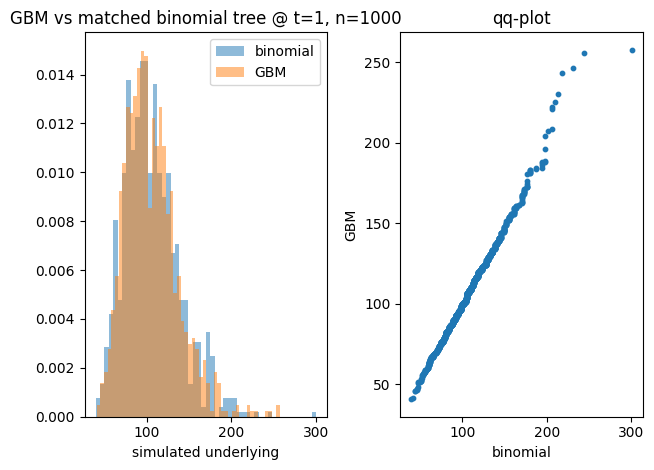

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_binomial(S0, u, d, p, n):
    """Simulate the process S_{n} = u^{X} d^{n-X} S_0 with X ~ Bin(n, p)"""
    X = np.random.binomial(n, p)
    S_n = S0 * (u ** X) * (d ** (n - X))
    return S_n

def simulate_GBM(S0, mu, sigma, t):
    """Simulate the geometric Brownian motion process S_{t}=S_{0} exp((r-sigma^2/2)t + sigma*W_{t})"""
    W_t = np.random.standard_normal()
    S_t = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W_t)
    return S_t

def match_parameters(t, r, sigma, n):
    """Calculate S0, u, d, p based on t, r, sigma, and n"""
    delta_t = t / n
    u = np.exp(sigma * np.sqrt(delta_t))
    d = 1 / u
    p = (np.exp(r * delta_t) - d) / (u - d)
    return  u, d, p

np.random.seed(42)
S0,r,sig,t,n = 100,0.05,0.30,1,1000
u,d,p = match_parameters(t, r, sig, n)

SSn_bin = [simulate_binomial(S0, u, d, p, n) for _ in range(1000)]
SSt_GBM = [simulate_GBM(S0, r, sig, t) for _ in range(1000)]

fig, axs = plt.subplots(1,2)
# histograms on first subplot
axs[0].hist(SSn_bin, bins=50, density=True, alpha=0.5, label="binomial")
axs[0].hist(SSt_GBM, bins=50, density=True, alpha=0.5, label="GBM")
axs[0].set_title("GBM vs matched binomial tree @ t=1, n=1000")
axs[0].set_xlabel("simulated underlying")
axs[0].legend()

#qq plots on second subplot
axs[1].scatter(np.sort(SSn_bin), np.sort(SSt_GBM),alpha=1,s=10)
axs[1].set_xlabel("binomial")
axs[1].set_ylabel("GBM")
axs[1].set_title("qq-plot")

plt.tight_layout()
plt.show()

# Pricing American Option under Binomial Model
We assume that the value of a product is equal to its discounted expected payoff.
For BS it can be proven this is the unique value for all risk averse investors by a delta hedging argument.
For the Binomial model this holds approximately. <br> 

American options may always be exercised by the holder. This makes the payoff
of the option also depend on choice. We define the value of the American option as the supremum of expected value of all choices (given only information up to that time). <br>

Finding the value of an American option under the Binomial model falls in the framework of MDP (Markov decision processes) 
i.e the underlying is a Markov chain and the rewards (the payoff) is also Markovian as it can be calculated with the current state (not path dependent) where the decision is made. As amount of states and decisions are finite, backward induction can obtain an optimal policy (optimal exercise time) and the expected reward (the value) for an American option.   

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def iter_states(n):
    """iterator for all possible states at time n"""
    for i in range(n+1):
        j = n - i
        yield i, j

def value_option_binomial(S0, u, d, p, n, dt,r,payoff,american=True):
    """calculates the best possible expected payoff for an american option"""
    # value of the option at maturity is the payoff
    value = {(i,j):payoff(u**i * d**j* S0) for i,j in iter_states(n)} 
    for time_step in range(n-1,-1,-1): # take steps backwards in time
        # value iteration
        for (i,j) in iter_states(time_step): # iterate over all possible states 
            value[(i,j)] = np.exp(-dt*r)*(p*value[(i+1,j)] + (1-p)*value[(i,j+1)])
            if american: # exercise decision
                value[(i,j)] = max(value[(i,j)],payoff(u**i * d**j* S0))
    return value

def value_option_binomial_array(S0, u, d, p, n, dt,r,payoff,american=True):
    """calculates the best possible expected payoff for an american option"""
    I,J = np.arange(n+1), n-np.arange(n+1)
    value = payoff(u**I * d**J * S0)
    for t in range(n-1,-1,-1): # take steps backwards in time
        I,J = np.arange(t+1), t-np.arange(t+1)
        value[:t+1]=np.exp(-dt*r)*(p*value[1:t+2] + (1-p)*value[:t+1])
        value[:t+1]=np.maximum(value[:t+1],american*payoff(u**I * d**J *S0)) 
    return value


In [9]:
def match_parameters(t, r, sigma, n):
    """Calculate S0, u, d, p based on t, r, sigma, and n"""
    dt = t / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    return  u, d, p

def payoff_put(S,K): return np.maximum(K-S,0)
def payoff_call(S,K): return np.maximum(S-K,0)

S0,mu,sig,t,n = 100,0.07,0.30,1,100
r = 0.02
u,d,p = match_parameters(t, mu, sig, n)
dt = t/n
K = 110

val_american = value_option_binomial(S0, u, d, p, n, dt,r,lambda S : payoff_put(S,K),american=True)
val_american_array = value_option_binomial_array(S0, u, d, p, n, dt,r,lambda S : payoff_put(S,K),american=True)
val_europian = value_option_binomial(S0, u, d, p, n, dt,r,lambda S: payoff_put(S,K),american=False)
val_europian_array = value_option_binomial_array(S0, u, d, p, n, dt,r,lambda S: payoff_put(S,K),american=False)
print(val_american[(0,0)],val_europian[(0,0)])
print(val_american_array[0],val_europian_array[0])

# def viz_val(val,n):
#     SS = [u**i * d**j* S0 for i in range(n+1) for j in [n-i]]
#     yy = [val[(i,j)] for i in range(n+1) for j in [n-i]]
#     plt.plot(SS,yy)

# for it in [1,5,10,15,20]:
#     viz_val(val,it)

# plt.show()

# for it in [1,5,10,15,20]:
#     viz_val(val_euro_call,it)

# plt.show()

15.204800148730051 14.112679917466158
15.204800148730051 14.112679917466158


# comparing to BS formula 

In [38]:
import scipy.stats

S0,mu,sig,t,n = 100,0.04,0.30,1,200
r = 0.04
u,d,p = match_parameters(t, mu, sig, n)
dt = t/n
K = 110

def bs_call_price(S, K, r, t, sigma):
    N = scipy.stats.norm.cdf
    d1 = (np.log(S/K) + (r+sigma**2/2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return N(d1) * S - N(d2) * K * np.exp(-r*t)

print("BS:",bs_call_price(S0,K,r,t,sig))

val_europian_call = value_option_binomial(S0, u, d, p, n, dt,r,lambda S: payoff_call(S,K),american=False)
val_american_call = value_option_binomial(S0, u, d, p, n, dt,r,lambda S: payoff_call(S,K),american=True)
val_europian_array_call = value_option_binomial_array(S0, u, d, p, n, dt,r,lambda S: payoff_call(S,K),american=False)
val_american_array_call = value_option_binomial_array(S0, u, d, p, n, dt,r,lambda S: payoff_call(S,K),american=True)
print(val_europian_call[(0,0)])
print(val_american_call[(0,0)])
print(val_europian_array_call[0])
print(val_american_array_call[0])

BS: 9.625357828843697
9.631223935389615
9.631223935389615
9.631223935389615
9.631223935389615
